In [1]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul


# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)


[[ 0.81702644 -0.46925877 -1.36653694  1.56318263 -0.4486765  -0.33132865
  -0.10121749]]


In [ ]:
def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [ ]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환

    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None


In [ ]:
def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 288 |  반복 1 / 2 | 시간 0[s] | 손실 0.98
| 에폭 289 |  반복 1 / 2 | 시간 0[s] | 손실 1.12
| 에폭 290 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 291 |  반복 1 / 2 | 시간 0[s] | 손실 1.00
| 에폭 292 |  반복 1 / 2 | 시간 0[s] | 손실 0.93
| 에폭 293 |  반복 1 / 2 | 시간 0[s] | 손실 1.08
| 에폭 294 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 295 |  반복 1 / 2 | 시간 0[s] | 손실 0.99
| 에폭 296 |  반복 1 / 2 | 시간 0[s] | 손실 0.99
| 에폭 297 |  반복 1 / 2 | 시간 0[s] | 손실 1.18
| 에폭 298 |  반복 1 / 2 | 시간 0[s] | 손실 0.90
| 에폭 299 |  반복 1 / 2 | 시간 0[s] | 손실 0.96
| 에폭 300 |  반복 1 / 2 | 시간 0[s] | 손실 1.09
| 에폭 301 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 302 |  반복 1 / 2 | 시간 0[s] | 손실 0.95
| 에폭 303 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 304 |  반복 1 / 2 | 시간 0[s] | 손실 1.06
| 에폭 305 |  반복 1 / 2 | 시간 0[s] | 손실 1.00
| 에폭 306 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 307 |  반복 1 / 2 | 시간 0[s] | 손실 1.03
| 에폭 308 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 309 |  반복 1 / 2 | 시간 0[s] | 손실 0.97
| 에폭 310 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 311 |  반복 1 / 2 | 시간 0[s] | 손실 0.99
| 에폭 312 |  반복 1

| 에폭 605 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 606 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 607 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 608 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 609 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 610 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 611 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 612 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 613 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 614 |  반복 1 / 2 | 시간 0[s] | 손실 0.44
| 에폭 615 |  반복 1 / 2 | 시간 0[s] | 손실 0.77
| 에폭 616 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 617 |  반복 1 / 2 | 시간 0[s] | 손실 0.76
| 에폭 618 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 619 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 620 |  반복 1 / 2 | 시간 0[s] | 손실 0.55
| 에폭 621 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 622 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 623 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 624 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 625 |  반복 1 / 2 | 시간 0[s] | 손실 0.72
| 에폭 626 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 627 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 628 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 629 |  반복 1

| 에폭 855 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 856 |  반복 1 / 2 | 시간 0[s] | 손실 0.50
| 에폭 857 |  반복 1 / 2 | 시간 0[s] | 손실 0.39
| 에폭 858 |  반복 1 / 2 | 시간 0[s] | 손실 0.41
| 에폭 859 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 860 |  반복 1 / 2 | 시간 0[s] | 손실 0.41
| 에폭 861 |  반복 1 / 2 | 시간 0[s] | 손실 0.50
| 에폭 862 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 863 |  반복 1 / 2 | 시간 0[s] | 손실 0.42
| 에폭 864 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 865 |  반복 1 / 2 | 시간 0[s] | 손실 0.39
| 에폭 866 |  반복 1 / 2 | 시간 0[s] | 손실 0.48
| 에폭 867 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 868 |  반복 1 / 2 | 시간 0[s] | 손실 0.31
| 에폭 869 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 870 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 871 |  반복 1 / 2 | 시간 0[s] | 손실 0.31
| 에폭 872 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 873 |  반복 1 / 2 | 시간 0[s] | 손실 0.46
| 에폭 874 |  반복 1 / 2 | 시간 0[s] | 손실 0.50
| 에폭 875 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 876 |  반복 1 / 2 | 시간 0[s] | 손실 0.56
| 에폭 877 |  반복 1 / 2 | 시간 0[s] | 손실 0.39
| 에폭 878 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 879 |  반복 1

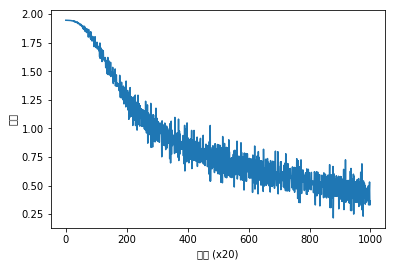

you [ 1.7103423  -0.90402746 -0.89712715 -0.9644634   0.9761773 ]
say [ 1.3000567   1.1861439   1.1307416   0.21552558 -1.1478355 ]
goodbye [-0.15410876 -1.0955526  -1.0709442  -0.8322115   1.0103027 ]
and [ 1.187885    0.384915    1.1225048   1.8747684  -0.76172864]
i [-0.15950133 -1.0915675  -1.0825887  -0.8499563   1.0045097 ]
hello [ 1.715482   -0.90612656 -0.9107861  -0.95637757  0.9676644 ]
. [ 0.99625677  1.3131921   0.3917445  -1.6902667  -1.1827638 ]


In [3]:
# coding: utf-8
import sys
sys.path.append('..')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.trainer import Trainer
from common.optimizer import Adam
from ch03.simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])


In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None


| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 3.87
| 에폭 26 |

| 에폭 208 |  반복 1 / 2 | 시간 0[s] | 손실 2.75
| 에폭 209 |  반복 1 / 2 | 시간 0[s] | 손실 2.91
| 에폭 210 |  반복 1 / 2 | 시간 0[s] | 손실 2.51
| 에폭 211 |  반복 1 / 2 | 시간 0[s] | 손실 2.74
| 에폭 212 |  반복 1 / 2 | 시간 0[s] | 손실 2.67
| 에폭 213 |  반복 1 / 2 | 시간 0[s] | 손실 2.76
| 에폭 214 |  반복 1 / 2 | 시간 0[s] | 손실 2.73
| 에폭 215 |  반복 1 / 2 | 시간 0[s] | 손실 2.45
| 에폭 216 |  반복 1 / 2 | 시간 0[s] | 손실 2.75
| 에폭 217 |  반복 1 / 2 | 시간 0[s] | 손실 2.67
| 에폭 218 |  반복 1 / 2 | 시간 0[s] | 손실 2.78
| 에폭 219 |  반복 1 / 2 | 시간 0[s] | 손실 2.47
| 에폭 220 |  반복 1 / 2 | 시간 0[s] | 손실 2.65
| 에폭 221 |  반복 1 / 2 | 시간 0[s] | 손실 2.61
| 에폭 222 |  반복 1 / 2 | 시간 0[s] | 손실 2.81
| 에폭 223 |  반복 1 / 2 | 시간 0[s] | 손실 2.56
| 에폭 224 |  반복 1 / 2 | 시간 0[s] | 손실 2.63
| 에폭 225 |  반복 1 / 2 | 시간 0[s] | 손실 2.64
| 에폭 226 |  반복 1 / 2 | 시간 0[s] | 손실 2.62
| 에폭 227 |  반복 1 / 2 | 시간 0[s] | 손실 2.48
| 에폭 228 |  반복 1 / 2 | 시간 0[s] | 손실 2.77
| 에폭 229 |  반복 1 / 2 | 시간 0[s] | 손실 2.61
| 에폭 230 |  반복 1 / 2 | 시간 0[s] | 손실 2.61
| 에폭 231 |  반복 1 / 2 | 시간 0[s] | 손실 2.62
| 에폭 232 |  반복 1

| 에폭 410 |  반복 1 / 2 | 시간 0[s] | 손실 2.27
| 에폭 411 |  반복 1 / 2 | 시간 0[s] | 손실 2.14
| 에폭 412 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 413 |  반복 1 / 2 | 시간 0[s] | 손실 2.34
| 에폭 414 |  반복 1 / 2 | 시간 0[s] | 손실 2.16
| 에폭 415 |  반복 1 / 2 | 시간 0[s] | 손실 2.34
| 에폭 416 |  반복 1 / 2 | 시간 0[s] | 손실 1.99
| 에폭 417 |  반복 1 / 2 | 시간 0[s] | 손실 2.37
| 에폭 418 |  반복 1 / 2 | 시간 0[s] | 손실 2.12
| 에폭 419 |  반복 1 / 2 | 시간 0[s] | 손실 2.26
| 에폭 420 |  반복 1 / 2 | 시간 0[s] | 손실 2.37
| 에폭 421 |  반복 1 / 2 | 시간 0[s] | 손실 2.07
| 에폭 422 |  반복 1 / 2 | 시간 0[s] | 손실 2.03
| 에폭 423 |  반복 1 / 2 | 시간 0[s] | 손실 2.37
| 에폭 424 |  반복 1 / 2 | 시간 0[s] | 손실 2.03
| 에폭 425 |  반복 1 / 2 | 시간 0[s] | 손실 2.28
| 에폭 426 |  반복 1 / 2 | 시간 0[s] | 손실 2.28
| 에폭 427 |  반복 1 / 2 | 시간 0[s] | 손실 2.11
| 에폭 428 |  반복 1 / 2 | 시간 0[s] | 손실 2.45
| 에폭 429 |  반복 1 / 2 | 시간 0[s] | 손실 1.97
| 에폭 430 |  반복 1 / 2 | 시간 0[s] | 손실 2.23
| 에폭 431 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 432 |  반복 1 / 2 | 시간 0[s] | 손실 2.36
| 에폭 433 |  반복 1 / 2 | 시간 0[s] | 손실 2.48
| 에폭 434 |  반복 1

| 에폭 622 |  반복 1 / 2 | 시간 0[s] | 손실 2.26
| 에폭 623 |  반복 1 / 2 | 시간 0[s] | 손실 1.77
| 에폭 624 |  반복 1 / 2 | 시간 0[s] | 손실 2.19
| 에폭 625 |  반복 1 / 2 | 시간 0[s] | 손실 2.00
| 에폭 626 |  반복 1 / 2 | 시간 0[s] | 손실 1.83
| 에폭 627 |  반복 1 / 2 | 시간 0[s] | 손실 2.22
| 에폭 628 |  반복 1 / 2 | 시간 0[s] | 손실 1.97
| 에폭 629 |  반복 1 / 2 | 시간 0[s] | 손실 1.77
| 에폭 630 |  반복 1 / 2 | 시간 0[s] | 손실 2.00
| 에폭 631 |  반복 1 / 2 | 시간 0[s] | 손실 2.22
| 에폭 632 |  반복 1 / 2 | 시간 0[s] | 손실 1.59
| 에폭 633 |  반복 1 / 2 | 시간 0[s] | 손실 2.24
| 에폭 634 |  반복 1 / 2 | 시간 0[s] | 손실 1.77
| 에폭 635 |  반복 1 / 2 | 시간 0[s] | 손실 2.18
| 에폭 636 |  반복 1 / 2 | 시간 0[s] | 손실 2.00
| 에폭 637 |  반복 1 / 2 | 시간 0[s] | 손실 1.79
| 에폭 638 |  반복 1 / 2 | 시간 0[s] | 손실 2.20
| 에폭 639 |  반복 1 / 2 | 시간 0[s] | 손실 2.02
| 에폭 640 |  반복 1 / 2 | 시간 0[s] | 손실 2.22
| 에폭 641 |  반복 1 / 2 | 시간 0[s] | 손실 1.76
| 에폭 642 |  반복 1 / 2 | 시간 0[s] | 손실 1.97
| 에폭 643 |  반복 1 / 2 | 시간 0[s] | 손실 1.76
| 에폭 644 |  반복 1 / 2 | 시간 0[s] | 손실 2.03
| 에폭 645 |  반복 1 / 2 | 시간 0[s] | 손실 2.21
| 에폭 646 |  반복 1

| 에폭 838 |  반복 1 / 2 | 시간 0[s] | 손실 2.12
| 에폭 839 |  반복 1 / 2 | 시간 0[s] | 손실 1.92
| 에폭 840 |  반복 1 / 2 | 시간 0[s] | 손실 1.71
| 에폭 841 |  반복 1 / 2 | 시간 0[s] | 손실 1.92
| 에폭 842 |  반복 1 / 2 | 시간 0[s] | 손실 2.14
| 에폭 843 |  반복 1 / 2 | 시간 0[s] | 손실 1.46
| 에폭 844 |  반복 1 / 2 | 시간 0[s] | 손실 2.14
| 에폭 845 |  반복 1 / 2 | 시간 0[s] | 손실 1.90
| 에폭 846 |  반복 1 / 2 | 시간 0[s] | 손실 1.70
| 에폭 847 |  반복 1 / 2 | 시간 0[s] | 손실 2.15
| 에폭 848 |  반복 1 / 2 | 시간 0[s] | 손실 2.14
| 에폭 849 |  반복 1 / 2 | 시간 0[s] | 손실 1.68
| 에폭 850 |  반복 1 / 2 | 시간 0[s] | 손실 1.69
| 에폭 851 |  반복 1 / 2 | 시간 0[s] | 손실 2.35
| 에폭 852 |  반복 1 / 2 | 시간 0[s] | 손실 1.91
| 에폭 853 |  반복 1 / 2 | 시간 0[s] | 손실 1.69
| 에폭 854 |  반복 1 / 2 | 시간 0[s] | 손실 1.93
| 에폭 855 |  반복 1 / 2 | 시간 0[s] | 손실 1.91
| 에폭 856 |  반복 1 / 2 | 시간 0[s] | 손실 2.14
| 에폭 857 |  반복 1 / 2 | 시간 0[s] | 손실 1.67
| 에폭 858 |  반복 1 / 2 | 시간 0[s] | 손실 1.91
| 에폭 859 |  반복 1 / 2 | 시간 0[s] | 손실 1.91
| 에폭 860 |  반복 1 / 2 | 시간 0[s] | 손실 1.91
| 에폭 861 |  반복 1 / 2 | 시간 0[s] | 손실 2.13
| 에폭 862 |  반복 1

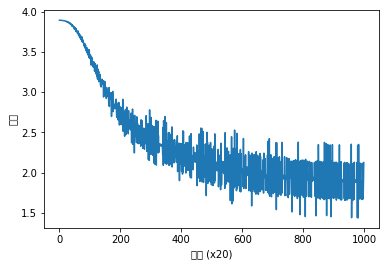

you [-0.00456591 -0.00273847 -0.01312623 -0.00401483 -0.00223373]
say [-0.556417   -1.0006167  -0.7536168  -0.80094033 -0.83036566]
goodbye [-1.1103957   0.78871197  0.76872045  0.75574946  0.7533262 ]
and [ 1.3934993  -0.8694058  -1.0348612  -0.9929893  -0.97511923]
i [-1.1120199   0.79087853  0.76325613  0.7613686   0.755852  ]
hello [1.2573297  0.9466383  0.8934191  0.89640266 0.8961218 ]
. [ 0.00241249 -0.00257517  0.00675048  0.0092788  -0.00222516]


In [4]:
# coding: utf-8
import sys
sys.path.append('..')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.trainer import Trainer
from common.optimizer import Adam
from ch03.simple_skip_gram import SimpleSkipGram
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])
